In [1]:
%matplotlib inline
import time
import os

from mxnet import ndarray as nd
import mxnet.autograd as ag
import mxnet.gluon as gluon
import mxnet as mx
from mxnet import init
from mxnet import image
from mxnet import sym

import numpy as np
import matplotlib.pyplot as plt
import cv2

from faster_rcnn.config import cfg
from faster_rcnn.faster_rcnn import FasterRCNN
from faster_rcnn.utils import imagenetNormalize, img_resize, img_resize_fix, bbox_inverse_transform, bbox_clip
from faster_rcnn.rpn_proposal import proposal_test
from faster_rcnn.nms import *
from TUPUFaceDataset import TUPUFaceDataset

/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/__init__.py:88: DeprecationWarning: invalid escape sequence \.
  args.extend(['--with-doctest', '--ignore-files=^\.',
/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/__init__.py:89: DeprecationWarning: invalid escape sequence \.
  '--ignore-files=^setup\.py$$', '--ignore-files=test'])
/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/_shared/_warnings.py:107: DeprecationWarning: invalid escape sequence \A
  """
/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/_shared/_warnings.py:112: DeprecationWarning: invalid escape sequence \A
  remaining = [m for m in matching if '\A\Z' not in m.split('|')]
/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/measure/_regionprops.py:610: DeprecationWarning: invalid escape sequence \*
  matches = re.finditer('\*\*(\w+)\*\* \:.*?\n(.*?)(?=\n    [\*\S]+)',
/usr/local/python-3.6.5/lib/python3.6/site-packages/skimage/transform/integral.py:32: Deprecation

In [2]:
# prepare testing dataset
def test_transformation(data, label):
    data = imagenetNormalize(data)
    return data, label

test_dataset = TUPUFaceDataset(
    ["/world/data-gpu-57/AR/zmp_working_dir/face_detect/wh9_16_shuffle_test.json"],
#     ["/world/data-gpu-112/zhanglinghan/big-face/big_faces.json"],
    transform=test_transformation,
    resize_func=img_resize_fix,
    shuffle=True
)

In [3]:
# load model from dynamic graph model & eport to static graph model
test_datait = mx.gluon.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
ctx = mx.cpu()
net = FasterRCNN(
    len(cfg.anchor_ratios) * len(cfg.anchor_scales), 
    cfg.num_classes, 
    pretrained_model="vgg16",
    feature_name="vgg0_conv12_fwd_output",
#     pretrained_model="mobilenetv2_0.5", 
#     feature_name="mobilenetv20_features_linearbottleneck12_batchnorm2_fwd_output",
    ctx=ctx)
net.init_params(ctx)
# net.collect_params().load("/world/data-gpu-112/zhanglinghan/face-detect-faster-rcnn-mx/faster-rcnn-vgg16-9anchors/faster-rcnn-vgg16-9anchors-140000.gluonmodel", ctx)
net.collect_params().load("/world/data-gpu-112/zhanglinghan/face-detect-faster-rcnn-mx/light-head-rcnn-vgg16-9anchors/light-head-rcnn-vgg16-9anchors-60000.gluonmodel", ctx)
# net.collect_params().load("/world/data-gpu-112/zhanglinghan/face-detect-faster-rcnn-mx/faster-rcnn-vgg16-9anchors-multi-gpu/faster-rcnn-vgg16-9anchors-multi-gpu-2000.gluonmodel", ctx)

In [4]:
def show_detection_result(data, label, bboxes, cls_scores, axis):
    _n, _c, h, w = data.shape
    data = data[0].as_in_context(mx.cpu(0))
    data[0] = data[0] * 0.229 + 0.485
    data[1] = data[1] * 0.224 + 0.456
    data[2] = data[2] * 0.225 + 0.406
    label = label[0].asnumpy()
    img = data.asnumpy()
#     img = np.array(np.round(img * 255), dtype=np.uint8)
    img = np.transpose(img, (1, 2, 0))
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    bboxes = bboxes.asnumpy()
    cls_scores = cls_scores.asnumpy()
    axis.imshow(img)
    
#     # Show ground truth
#     for bbox in label:
#         axis.add_patch(plt.Rectangle((int(bbox[0]), int(bbox[1])), int(bbox[2])-int(bbox[0]), int(bbox[3])-int(bbox[1]), fill=False, edgecolor="green"))

    # NMS by class
    for cls_id in range(1, 2):
        cur_scores = cls_scores[:, cls_id]
        bboxes_pick = bboxes[:, cls_id * 4: (cls_id+1)*4]
        cur_scores, bboxes_pick = nms(cur_scores, bboxes_pick, cfg.rcnn_nms_thresh)
        print(cur_scores.shape)
        for i in range(len(cur_scores)):
            if cur_scores[i] >= 0.8:
                bbox = bboxes_pick[i]
                axis.add_patch(plt.Rectangle((int(bbox[0]), int(bbox[1])), int(bbox[2])-int(bbox[0]), int(bbox[3])-int(bbox[1]), fill=False, edgecolor="blue"))
    
    for x in range(int(h / 16)):
        axis.axhline(16.0 * x, lw=0.5, color='green', zorder=5)
    for x in range(int(w / 16)):
        axis.axvline(16.0 * x, lw=0.5, color='green', zorder=5)
                

(210,)
(218,)
(193,)
(214,)
(225,)
(238,)
(200,)
(184,)
(182,)
(200,)
(183,)
(183,)
(174,)
(187,)
(154,)
(163,)
(204,)
(210,)
(188,)
(136,)


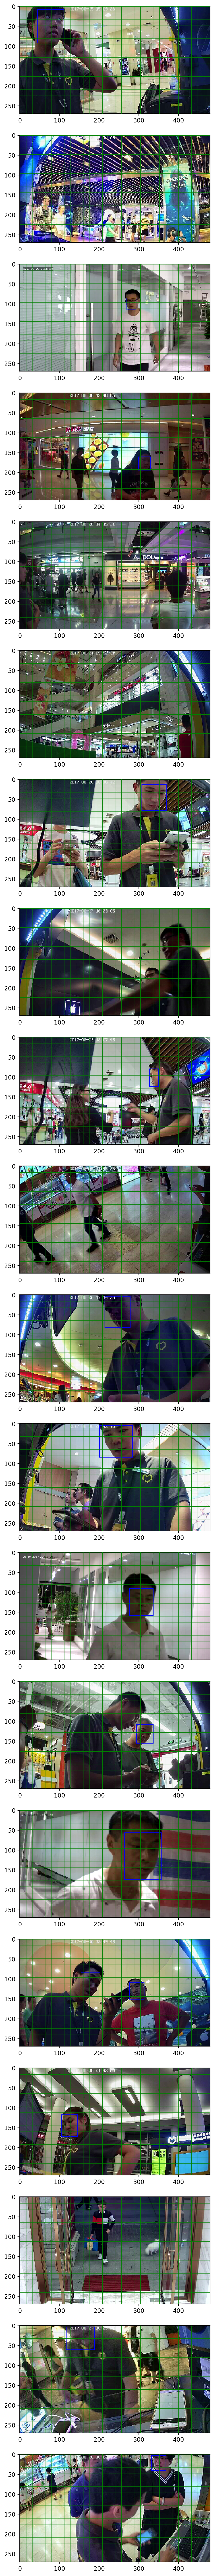

In [5]:
num_img = test_dataset.__len__()
num_img = 20
figs, axises = plt.subplots(num_img, 1, figsize=(40, 80))
plt.gcf().set_dpi(200)
for it, (data, label) in enumerate(test_datait):
    if it >= num_img:
        break
    data = data.as_in_context(ctx)
#     data = mx.ndarray.ones((1, 3, 270, 480), ctx=ctx) * 0.5
    _n, _c, h, w = data.shape
    label = label.as_in_context(ctx)
    rpn_cls, rpn_reg, f = net.rpn(data)
    f_height = f.shape[2]
    f_width = f.shape[3]
    rpn_bbox_pred = proposal_test(rpn_cls, rpn_reg, f.shape, data.shape, ctx)

    # RCNN part
    # add batch dimension
    rpn_bbox_pred_attach_batchid = mx.nd.concatenate([mx.nd.zeros((rpn_bbox_pred.shape[0], 1), ctx), rpn_bbox_pred], axis=1)
    f = mx.nd.ROIPooling(f, rpn_bbox_pred_attach_batchid, (7, 7), 1.0 / 16) # VGG16 based spatial stride=16
    rcnn_cls, rcnn_reg = net.rcnn(f)
    rcnn_bbox_pred = mx.nd.zeros(rcnn_reg.shape)
    for i in range(2):
        rcnn_bbox_pred[:, i*4:(i+1)*4] = bbox_clip(bbox_inverse_transform(rpn_bbox_pred, rcnn_reg[:, i*4:(i+1)*4]), h, w)
    rcnn_cls = mx.nd.softmax(rcnn_cls)
    show_detection_result(data, label, rcnn_bbox_pred, rcnn_cls, axises[it])
plt.show()

In [6]:
save_path = "/world/data-gpu-112/zhanglinghan/face-detect-faster-rcnn-mx/faster-rcnn-mobilenetv2_0.5-9anchors"
_n, _c, h, w = (1, 3, 360, 640)
net.rpn.hybridize()
rpn_cls, rpn_reg, f = net.rpn(mx.ndarray.ones(shape=(_n, _c, h, w), ctx=ctx))
net.rpn.export(os.path.join(save_path, "faster-rcnn-mobilenetv2_0.5-9anchors-rpn"))

# symnet = mx.symbol.load(os.path.join(save_path, "faster-rcnn-mobilenetv2_0.5-9anchors-rpn-symbol.json"))
# mx.viz.plot_network(symnet)

In [7]:
# _n, _c = (1, 1176)    # mbnetv2_0.25
_n, _c = (1, 2352)    # mbnetv2_0.25
# _n, _c = (1, 25088)    # vgg16
net.rcnn.hybridize()
rcnn_cls, rcnn_reg = net.rcnn(mx.ndarray.ones(shape=(_n, _c), ctx=ctx))
net.rcnn.export(os.path.join(save_path, "faster-rcnn-mobilenetv2_0.5-9anchors-rcnn"))

# symnet = mx.symbol.load(os.path.join(save_path, "faster-rcnn-mobilenetv2_0.5-9anchors-rcnn-symbol.json"))
# mx.viz.plot_network(symnet)

MXNetError: Error in operator dense0_fwd: Shape inconsistent, Provided = [2048,24010], inferred shape=(2048,2352)